In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# split node into classes 
def nodeSplit(nodeData):
    class1 = []
    class2 = []
    for i in range(np.shape(nodeData)[0]):
        if nodeData[i,2] == 0:
            class1.append(nodeData[i])
        else:
            class2.append(nodeData[i])
    
    return np.array(class1), np.array(class2)

# calculate class probabilities
def nodeProb(nodeData):
    data1, data2 = nodeSplit(nodeData)
    return np.size(data1)/np.size(nodeData), np.size(data2)/np.size(nodeData)

# class probabilities for weighted samples
def nodeProbWeight(nodeData):
    data1, data2 = nodeSplit(nodeData)

    sum1 = 0
    sum2 = 0
    if np.size(data1)>0:
        sum1 = np.sum(data1[:,3])   
    if np.size(data2)>0:
        sum2 = np.sum(data2[:,3])

    return sum1/(sum1+sum2), sum2/(sum1+sum2)

# return most common class
def nodeClass(nodeData):
    prob1, prob2 = nodeProb(nodeData)
    if prob1 >= prob2:
        return 0
    else:
        return 1

# Gini impurity
def gini(tData):
    nData = np.size(tData)  
    count = np.bincount(tData.astype(int))
    if np.size(count) > 1:
        if count[0] > 0:  
            return 1 - ((count[0]/nData)**2) - ((count[1]/nData)**2)
        else:
            return 0
    else:
        return 0

# weighted Gini impurity
def giniWeight(tData, weights):
    nData = np.size(tData)
    sum1 = 0
    sum2 = 0

    for i in range(nData):
        if tData[i] == 0:
            sum1 += weights[i]
        else:
            sum2 += weights[i]

    if nData > 0:
        return 1 - ((sum1/(sum1+sum2))**2) - ((sum2/(sum1+sum2))**2)
    else:
        return 0

# CART cost function for classification
def cart(tLeft,tRight):
    return (np.size(tLeft)*gini(tLeft)/(np.size(tLeft)+np.size(tRight))) + (np.size(tRight)*gini(tRight)/(np.size(tLeft)+np.size(tRight)))

# weighted CART cost function
def cartWeight(tLeft,tRight,weightsLeft,weightsRight):
    return (np.sum(weightsLeft)*giniWeight(tLeft,weightsLeft)/(np.sum(weightsLeft)+np.sum(weightsRight))) + (np.sum(weightsRight)*giniWeight(tRight,weightsRight)/(np.sum(weightsLeft)+np.sum(weightsRight)))

# find optimal node splitting
def split(nodeData, minSampLeaf = 1):
    nData = np.shape(nodeData)[0]

    # sort data by x values
    ind = np.argsort(nodeData[:,0])
    xsort = nodeData[ind,0]
    ysort = nodeData[ind,1]
    tsort = nodeData[ind,2]
    xsortData = np.vstack([xsort,ysort,tsort]).T

    minCost = cart(xsortData[0:minSampLeaf,2],xsortData[minSampLeaf:nData,2])  
    minIndex = minSampLeaf
    minFeat = 0
    for i in range(minSampLeaf+1,nData-minSampLeaf+1):
        cost = cart(xsortData[0:i,2],xsortData[i:nData,2])
        
        if cost < minCost:
            minCost = cost
            minIndex = i

    # sort data by y values
    ind = np.argsort(nodeData[:,1])
    xsort = nodeData[ind,0]
    ysort = nodeData[ind,1]
    tsort = nodeData[ind,2]
    ysortData = np.vstack([xsort,ysort,tsort]).T

    for i in range(minSampLeaf,nData-minSampLeaf+1):
        cost = cart(ysortData[0:i,2],ysortData[i:nData,2])
        
        if cost < minCost:
            minCost = cost
            minIndex = i
            minFeat = 1

    if minFeat == 0:
        return xsortData[0:minIndex], xsortData[minIndex:nData], minFeat, minCost
    else:
        return ysortData[0:minIndex], ysortData[minIndex:nData], minFeat, minCost

# splitting with weighted samples
def splitWeight(nodeData, minSampLeaf = 1):
    nData = np.shape(nodeData)[0]

    # sort data by x values
    ind = np.argsort(nodeData[:,0])
    xsort = nodeData[ind,0]
    ysort = nodeData[ind,1]
    tsort = nodeData[ind,2]
    wsort = nodeData[ind,3]
    xsortData = np.vstack([xsort,ysort,tsort,wsort]).T

    minCost = cartWeight(xsortData[0:minSampLeaf,2],xsortData[minSampLeaf:nData,2],xsortData[0:minSampLeaf,3],xsortData[minSampLeaf:nData,3])  
    minIndex = minSampLeaf
    minFeat = 0
    for i in range(minSampLeaf+1,nData-minSampLeaf+1):
        cost = cartWeight(xsortData[0:i,2],xsortData[i:nData,2],xsortData[0:i,3],xsortData[i:nData,3])
        
        if cost < minCost:
            minCost = cost
            minIndex = i

    # sort data by y values
    ind = np.argsort(nodeData[:,1])
    xsort = nodeData[ind,0]
    ysort = nodeData[ind,1]
    tsort = nodeData[ind,2]
    wsort = nodeData[ind,3]
    ysortData = np.vstack([xsort,ysort,tsort,wsort]).T

    for i in range(minSampLeaf,nData-minSampLeaf+1):
        cost = cartWeight(ysortData[0:i,2],ysortData[i:nData,2],ysortData[0:i,3],ysortData[i:nData,3])
        
        if cost < minCost:
            minCost = cost
            minIndex = i
            minFeat = 1

    if minFeat == 0:
        return xsortData[0:minIndex], xsortData[minIndex:nData], minFeat, minCost
    else:
        return ysortData[0:minIndex], ysortData[minIndex:nData], minFeat, minCost

# define class for tree nodes
class TreeNode:
    def __init__(self, key, data, value, gini):
        self.key = key
        self.data = data
        self.value = value
        self.gini = gini
        self.feat = None
        self.thresh = None
        self.left = None
        self.right = None

# return class probabilities for test point
def yhatTree(x, y, root):
    node = root
    while node.feat != None:
        if node.feat == 0:
            if x <= node.thresh:
                node = node.left
            else:
                node = node.right
        else:
            if y <= node.thresh:
                node = node.left
            else:
                node = node.right

    return node.value

# output average of bagged trees
def yhatBag(x, y, treeList):
    sum = 0
    for i in range(len(treeList)):
        sum += yhatTree(x, y, treeList[i])
    return sum/len(treeList)

# output average of boosted tree
def yhatBoost(x, y, treeList, weights, thresh):
    sum1 = 0
    sum2 = 0
    for i in range(len(treeList)):
        yhat = yhatTree(x, y, treeList[i])
        if yhat <= thresh:
            sum1 += weights[i]
        else:
            sum2 += weights[i]
    
    return sum2/(sum1+sum2)

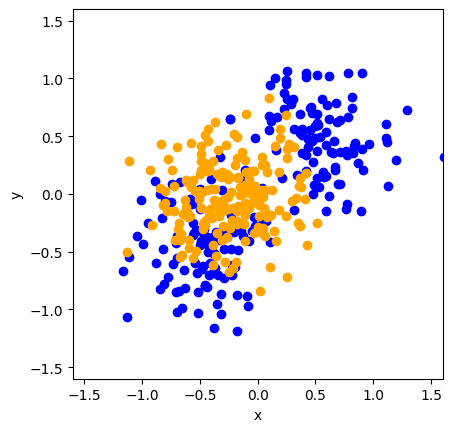

In [26]:
# set up training data for two classes
# first class is centered around two gaussians in opposite quadrants
n1 = 100
mu_x1 = -0.5
mu_y1 = -0.5
sig_x1 = 0.3
sig_y1 = 0.3

# random sampling of x 
x1rng = np.random.default_rng(seed=504)
x1 = x1rng.normal(loc=mu_x1,scale=sig_x1,size=n1)

# random sampling of y 
y1rng = np.random.default_rng(seed=569)
y1 = y1rng.normal(loc=mu_y1,scale=sig_y1,size=n1)

n2 = 100
mu_x2 = -mu_x1
mu_y2 = -mu_y1
sig_x2 = 0.3
sig_y2 = 0.3

# random sampling of x 
x2rng = np.random.default_rng(seed=9630)
x2 = x2rng.normal(loc=mu_x2,scale=sig_x2,size=n2)

# random sampling of y 
y2rng = np.random.default_rng(seed=1902)
y2 = y2rng.normal(loc=mu_y2,scale=sig_y2,size=n2)

# merge with data from first Gaussian
x1 = np.concatenate((x1,x2))
y1 = np.concatenate((y1,y2))

# second class is centered around gaussian closer to the origin
n3 = 200
mu_x3 = -0.25
mu_y3 = 0.0
sig_x3 = 0.3
sig_y3 = 0.3

# random sampling of x 
x3rng = np.random.default_rng(seed=234)
x3 = x3rng.normal(loc=mu_x3,scale=sig_x3,size=n3)

# random sampling of y 
y3rng = np.random.default_rng(seed=719)
y3 = y3rng.normal(loc=mu_y3,scale=sig_y3,size=n3)

# define datasets
n = np.size(x1) + np.size(x3)
data1 = np.vstack((x1,y1,np.zeros(200))).T
data2 = np.vstack((x3,y3,np.ones(200))).T
data = np.concatenate((data1,data2))

# make plots
plt.scatter(x1,y1, c="blue")
plt.scatter(x3,y3, c="orange")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect('equal')
plt.gca().set_xlim(left = -1.6 , right = 1.6)
plt.gca().set_ylim(bottom = -1.6 , top = 1.6)
plt.show()

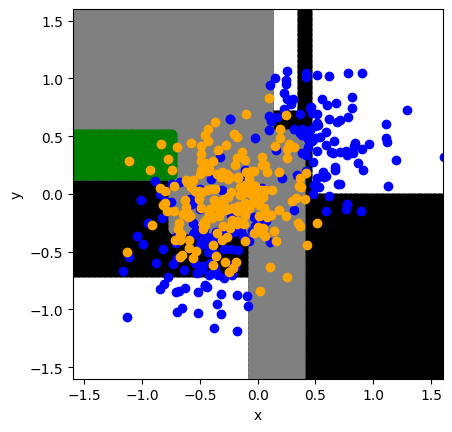

In [33]:
# build decision tree with max depth
maxDepth = 5
# minimum number of samples in a leaf
minSamples = 5

# initalize root node
rootTree = TreeNode('00', data=data, value=nodeProb(data)[1], gini=gini(data[:,2]))

# grow the tree iteratively
nodeList = [rootTree]
depth = 1
while depth <= maxDepth and len(nodeList) > 0:
    
    # iterate over nodes at each depth
    nextList = []
    width = 0
    for node in nodeList:
        
        # try to split the node to minimize cost 
        leftData, rightData, feat, cost = split(node.data, minSampLeaf=minSamples)
        
        # only split if new nodes have enough samples and impurity is reduced
        if np.shape(leftData)[0] >= minSamples and np.shape(rightData)[0] >= minSamples and cost < node.gini:

            node.left = TreeNode(str(depth)+str(width), leftData, nodeProb(leftData)[1], gini(leftData[:,2]))
            node.right = TreeNode(str(depth)+str(width+1), rightData, nodeProb(rightData)[1], gini(rightData[:,2]))
            node.feat = feat
            node.thresh = leftData[-1, feat] + ((rightData[0,feat]-leftData[-1, feat])/2)
            nextList.append(node.left)
            nextList.append(node.right)
            width += 2
    
    nodeList = nextList
    depth += 1

# now map decision regions
xgrid =  np.linspace(-1.6, 1.6, 300)
ygrid =  np.linspace(-1.6, 1.6, 300)

threshA = 0.05
class2xA = []
class2yA = []

threshB = 0.5
class2xB = []
class2yB = []

threshC = 0.95
class2xC = []
class2yC = []

for i in range(xgrid.size):   
    for j in range(ygrid.size):
        yhat = yhatTree(xgrid[i],ygrid[j],rootTree)
        if yhat > threshA:
            class2xA.append(xgrid[i])
            class2yA.append(ygrid[j])

            if yhat > threshB:
                class2xB.append(xgrid[i])
                class2yB.append(ygrid[j])

                if yhat > threshC:
                    class2xC.append(xgrid[i])
                    class2yC.append(ygrid[j])

class2xAarr = np.array(class2xA)
class2yAarr = np.array(class2yA)

class2xBarr = np.array(class2xB)
class2yBarr = np.array(class2yB)

class2xCarr = np.array(class2xC)
class2yCarr = np.array(class2yC)

# make plots
plt.scatter(class2xAarr,class2yAarr, c="black")
plt.scatter(class2xBarr,class2yBarr, c="grey")
plt.scatter(class2xCarr,class2yCarr, c="green")
plt.scatter(x1,y1, c="blue")
plt.scatter(x3,y3, c="orange")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect('equal')
plt.gca().set_xlim(left = -1.6 , right = 1.6)
plt.gca().set_ylim(bottom = -1.6 , top = 1.6)
plt.show()


In [22]:
import graphviz

def preorder_traversal(root, dot):
    if root:
        if root.feat == None:
            labelstr = 'key = '+root.key+'\nvalue = '+str(np.round(root.value, decimals = 2))+'\ngini = '+str(np.round(root.gini, decimals = 2))
        else:
            labelstr = 'key = '+root.key+'\nvalue = '+str(np.round(root.value, decimals = 2))+'\nfeature = '+str(root.feat)+'\nthreshold = '+str(np.round(root.thresh, decimals = 2))+'\ngini = '+str(np.round(root.gini, decimals = 2))
        dot.node(root.key, label=labelstr)
        if root.left:
            dot.edge(root.key, root.left.key, style='dotted')
        if root.right:
            dot.edge(root.key, root.right.key, style='dotted')
        preorder_traversal(root.left, dot)
        preorder_traversal(root.right, dot)

def visualize_binary_tree(root):
    dot_preorder = graphviz.Digraph(comment='Preorder Traversal')
    preorder_traversal(root, dot_preorder)
    dot_preorder.render('preorder_traversal', view=True, format='png')

visualize_binary_tree(rootTree)

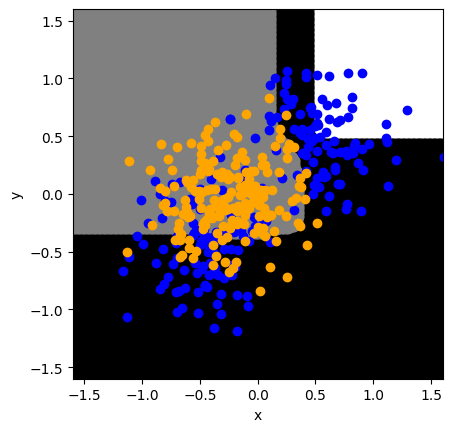

In [37]:
# now want to bag ensemble of trees
nTrees = 300
# training sample size for each tree
nSample = 50

# save trees
treeBagCol = []
for iTree in range(nTrees):
    # sample data set and sort subsample
    dataRandrng = np.random.default_rng()
    dataRand = dataRandrng.choice(data, nSample)

    # initalize root node
    root = TreeNode('00', data=dataRand, value=nodeProb(dataRand)[1], gini=gini(dataRand[:,2]))

    # grow the tree iteratively
    nodeList = [root]
    depth = 1
    while depth <= maxDepth and len(nodeList) > 0:
    
        # iterate over nodes at each depth
        nextList = []
        width = 0
        for node in nodeList:
        
            # try to split the node to minimize cost 
            leftData, rightData, feat, cost = split(node.data, minSampLeaf=minSamples)
        
            # only split if new nodes have enough samples and impurity is reduced
            if np.shape(leftData)[0] >= minSamples and np.shape(rightData)[0] >= minSamples and cost < node.gini:

                node.left = TreeNode(str(depth)+str(width), leftData, nodeProb(leftData)[1], gini(leftData[:,2]))
                node.right = TreeNode(str(depth)+str(width+1), rightData, nodeProb(rightData)[1], gini(rightData[:,2]))
                node.feat = feat
                node.thresh = leftData[-1, feat] + ((rightData[0,feat]-leftData[-1, feat])/2)
                nextList.append(node.left)
                nextList.append(node.right)
                width += 2
    
        nodeList = nextList
        depth += 1

    treeBagCol.append(root)

# now map decision regions
xgrid =  np.linspace(-1.6, 1.6, 300)
ygrid =  np.linspace(-1.6, 1.6, 300)

threshA = 0.05
class2xA = []
class2yA = []

threshB = 0.5
class2xB = []
class2yB = []

threshC = 0.95
class2xC = []
class2yC = []

for i in range(xgrid.size):   
    for j in range(ygrid.size):
        yhat = yhatBag(xgrid[i],ygrid[j],treeBagCol)
        if yhat > threshA:
            class2xA.append(xgrid[i])
            class2yA.append(ygrid[j])

            if yhat > threshB:
                class2xB.append(xgrid[i])
                class2yB.append(ygrid[j])

                if yhat > threshC:
                    class2xC.append(xgrid[i])
                    class2yC.append(ygrid[j])

class2xAarr = np.array(class2xA)
class2yAarr = np.array(class2yA)

class2xBarr = np.array(class2xB)
class2yBarr = np.array(class2yB)

class2xCarr = np.array(class2xC)
class2yCarr = np.array(class2yC)

# make plots
plt.scatter(class2xAarr,class2yAarr, c="black")
plt.scatter(class2xBarr,class2yBarr, c="grey")
plt.scatter(class2xCarr,class2yCarr, c="green")
plt.scatter(x1,y1, c="blue")
plt.scatter(x3,y3, c="orange")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect('equal')
plt.gca().set_xlim(left = -1.6 , right = 1.6)
plt.gca().set_ylim(bottom = -1.6 , top = 1.6)
plt.show()

iTree =  0 tree weight =  0.016769482039608288
iTree =  1 tree weight =  0.007563466427970475
iTree =  2 tree weight =  0.007470753219796012
iTree =  3 tree weight =  0.00737901846109426
iTree =  4 tree weight =  0.007288254245465773
iTree =  5 tree weight =  0.007198452713215671
iTree =  6 tree weight =  0.0071096060504928695
iTree =  7 tree weight =  0.007021706488462153
iTree =  8 tree weight =  0.006934746302508747
iTree =  9 tree weight =  0.006848717811475576
iTree =  10 tree weight =  0.006763613376931662
iTree =  11 tree weight =  0.00667942540247222
iTree =  12 tree weight =  0.00659614633304968
iTree =  13 tree weight =  0.00651376865433461
iTree =  14 tree weight =  0.00643228489210688
iTree =  15 tree weight =  0.00635168761167613
iTree =  16 tree weight =  0.005925023813454855
iTree =  17 tree weight =  0.007191678774361925
iTree =  18 tree weight =  0.0061301431494251825
iTree =  19 tree weight =  0.005712537799441485
iTree =  20 tree weight =  0.006314838495109031
iTree 

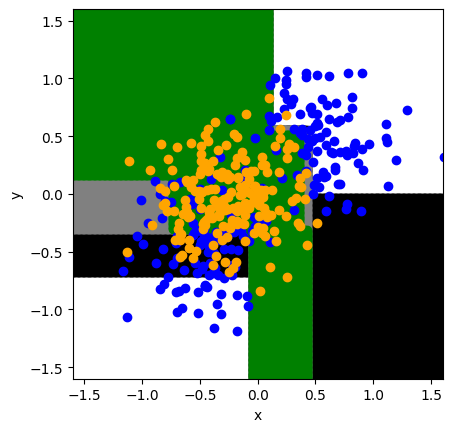

In [34]:
# now train a (ada)boosted ensemble
nTrees = 300
learnRate = 0.01
# set classification threshold for trees
threshClass2 = 0.4

# initalize weights for error rate in data
dataWeight = np.vstack([data[:,0],data[:,1],data[:,2],np.ones(n)/n]).T
dataWeight1, dataWeight2 = nodeSplit(dataWeight)
# save trees and tree weights
treeBoostCol = []
alphaCol = np.zeros(nTrees)
for iTree in range(nTrees):
    # initalize root node
    root = TreeNode('00', data=dataWeight, value=nodeProbWeight(dataWeight)[1], gini=giniWeight(dataWeight[:,2],dataWeight[:,3]))

    # grow the tree iteratively
    nodeList = [root]
    depth = 1
    while depth <= maxDepth and len(nodeList) > 0:
    
        # iterate over nodes at each depth
        nextList = []
        width = 0
        for node in nodeList:
        
            # try to split the node to minimize cost 
            leftData, rightData, feat, cost = splitWeight(node.data, minSampLeaf=minSamples)
        
            # only split if new nodes have enough samples and impurity is reduced
            if np.shape(leftData)[0] >= minSamples and np.shape(rightData)[0] >= minSamples and cost < node.gini:

                node.left = TreeNode(str(depth)+str(width), leftData, nodeProbWeight(leftData)[1], giniWeight(leftData[:,2],leftData[:,3]))
                node.right = TreeNode(str(depth)+str(width+1), rightData, nodeProbWeight(rightData)[1], giniWeight(rightData[:,2],rightData[:,3]))
                node.feat = feat
                node.thresh = leftData[-1, feat] + ((rightData[0,feat]-leftData[-1, feat])/2)
                nextList.append(node.left)
                nextList.append(node.right)
                width += 2
    
        nodeList = nextList
        depth += 1

    treeBoostCol.append(root)

    # calculate weighted error for tree
    error = 0
    misClass1 = []
    misClass2 = []
    for i in range(np.shape(dataWeight1)[0]):
        if yhatTree(dataWeight1[i,0], dataWeight1[i,1], root) > threshClass2:
            error += dataWeight1[i,3]
            misClass1.append(i)
    for i in range(np.shape(dataWeight2)[0]):
        if yhatTree(dataWeight2[i,0], dataWeight2[i,1], root) <= threshClass2:
            error += dataWeight2[i,3]
            misClass2.append(i)

    if error > 0:
        # calculate predictor weight
        alphaCol[iTree] = learnRate*np.log((1 - error) / error)
        print('iTree = ',iTree,'tree weight = ',alphaCol[iTree])

        # adjust weights for missclassified points
        for iWeight in misClass1:
            dataWeight1[iWeight,3] *= np.exp(alphaCol[iTree])
        for iWeight in misClass2:
            dataWeight2[iWeight,3] *= np.exp(alphaCol[iTree])

        # normalize weights
        dataWeight1[:,3] /= np.sum(dataWeight1[:,3])
        dataWeight2[:,3] /= np.sum(dataWeight2[:,3])

        # update dataset with new weights
        dataWeight = np.concatenate((dataWeight1,dataWeight2))

    else:
        iTree = nTrees

# now map decision regions
xgrid =  np.linspace(-1.6, 1.6, 300)
ygrid =  np.linspace(-1.6, 1.6, 300)

threshA = 0.05
class2xA = []
class2yA = []

threshB = 0.5
class2xB = []
class2yB = []

threshC = 0.95
class2xC = []
class2yC = []

for i in range(xgrid.size):   
    for j in range(ygrid.size):
        yhat = yhatBoost(xgrid[i], ygrid[j], treeBoostCol, alphaCol, threshClass2)
        if yhat > threshA:
            class2xA.append(xgrid[i])
            class2yA.append(ygrid[j])

            if yhat > threshB:
                class2xB.append(xgrid[i])
                class2yB.append(ygrid[j])

                if yhat > threshC:
                    class2xC.append(xgrid[i])
                    class2yC.append(ygrid[j])

class2xAarr = np.array(class2xA)
class2yAarr = np.array(class2yA)

class2xBarr = np.array(class2xB)
class2yBarr = np.array(class2yB)

class2xCarr = np.array(class2xC)
class2yCarr = np.array(class2yC)

# make plots
plt.scatter(class2xAarr,class2yAarr, c="black")
plt.scatter(class2xBarr,class2yBarr, c="grey")
plt.scatter(class2xCarr,class2yCarr, c="green")
plt.scatter(x1,y1, c="blue")
plt.scatter(x3,y3, c="orange")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect('equal')
plt.gca().set_xlim(left = -1.6 , right = 1.6)
plt.gca().set_ylim(bottom = -1.6 , top = 1.6)
plt.show()

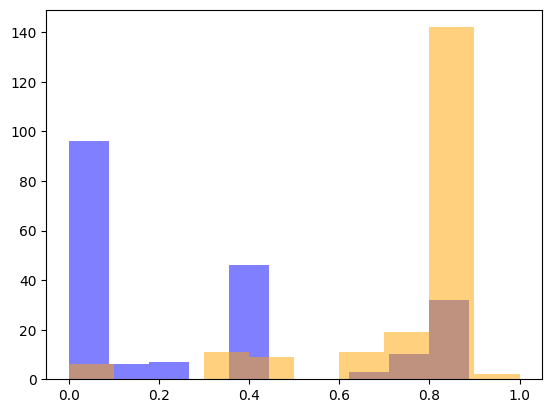

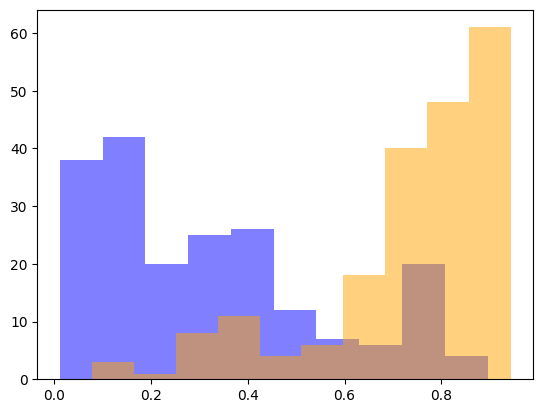

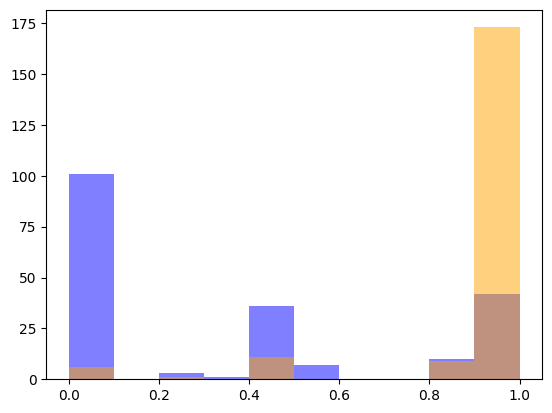

In [38]:
# get test data to see how well model generalizes
# random sampling of x 
x1testrng = np.random.default_rng()
x1test = x1testrng.normal(loc=mu_x1,scale=sig_x1,size=n1)

# random sampling of y 
y1testrng = np.random.default_rng()
y1test = y1testrng.normal(loc=mu_y1,scale=sig_y1,size=n1)

# random sampling of x 
x2testrng = np.random.default_rng()
x2test = x2testrng.normal(loc=mu_x2,scale=sig_x2,size=n2)

# random sampling of y 
y2testrng = np.random.default_rng()
y2test = y2testrng.normal(loc=mu_y2,scale=sig_y2,size=n2)

# merge with data from first Gaussian
x1test = np.concatenate((x1test,x2test))
y1test = np.concatenate((y1test,y2test))

# random sampling of x 
x3testrng = np.random.default_rng()
x3test = x3testrng.normal(loc=mu_x3,scale=sig_x3,size=n3)

# random sampling of y 
y3testrng = np.random.default_rng()
y3test = y3testrng.normal(loc=mu_y3,scale=sig_y3,size=n3)

# define test datasets
n1test = n1 + n2
n2test = n3
data1test = np.vstack((x1test,y1test)).T
data2test = np.vstack((x3test,y3test)).T

# plot distributions of scores for test data
score1Tree = np.zeros(n1test)
for i in range(n1test):
    score1Tree[i] = yhatTree(data1test[i,0],data1test[i,1],rootTree)

score2Tree = np.zeros(n2test)
for i in range(n2test):
    score2Tree[i] = yhatTree(data2test[i,0],data2test[i,1],rootTree)

score1Bag = np.zeros(n1test)
for i in range(n1test):
    score1Bag[i] = yhatBag(data1test[i,0],data1test[i,1],treeBagCol)

score2Bag = np.zeros(n2test)
for i in range(n2test):
    score2Bag[i] = yhatBag(data2test[i,0],data2test[i,1],treeBagCol)

score1Boost = np.zeros(n1test)
for i in range(n1test):
    score1Boost[i] = yhatBoost(data1test[i,0],data1test[i,1],treeBoostCol,alphaCol,threshClass2)

score2Boost = np.zeros(n2test)
for i in range(n2test):
    score2Boost[i] = yhatBoost(data2test[i,0],data2test[i,1],treeBoostCol,alphaCol,threshClass2)

# make plots
plt.hist(score1Tree, alpha=0.5, color='blue')
plt.hist(score2Tree, alpha=0.5, color='orange')
plt.show()

plt.hist(score1Bag, alpha=0.5, color='blue')
plt.hist(score2Bag, alpha=0.5, color='orange')
plt.show()

plt.hist(score1Boost, alpha=0.5, color='blue')
plt.hist(score2Boost, alpha=0.5, color='orange')
plt.show()